In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *


set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2

# Here are some useful labels to use for plotting throughout notebook
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}


st40_phys_viewer can not be loaded from outside Tokamak Energy!



# Read balance file

In [2]:
eqb = dict()


balancepath =  r"C:\Users\mikek\OneDrive\Project\DLS\from_david\2023-11-30 - New SPR45 balance file\balance.nc"

for sepadd in [0,9]:

    eqb[sepadd] = dict()

    for side in ["il", "ol"]: 
        eqb[sepadd][side] = unpackConfigurationMK(File =balancepath, 
                                                Type = side, sepadd=sepadd, resolution = 1000)
        
        keys = list(eqb[sepadd][side].keys())
        for key in keys:
            
            if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
                eqb[sepadd][side].pop(key, None)
            
    # file_write(eqb, "equilibrium.pkl")

# Setup and run DLS

In [3]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

In [5]:
cvar = "density"
design = "SPR45_new"

store = dict()

for sepadd in [0]:
    store[sepadd] = dict()
    for cvar in ["density", "impurity_frac", "power"]:
        store[sepadd][cvar] = dict()
        
        for side in ["il", "ol"]:
        # for side in ["il"]:
            d = eqb[sepadd][side].copy() # Load in single profile into dictionary "d"
            constants = constants_default.copy() # Set settings to default
            radios = radios_default.copy() # Set settings to default
            SparRange = np.linspace(0, d["S"][d["Xpoint"]], 200) # Solve at these parallel positions

            # These come from Stuart's unmitigated loads
            if "i" in side:
                constants["qpllu0"] = 1.5e9
            if "o" in side:
                constants["qpllu0"] = 1.5*1.5e9  
            

            results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-4, Ttol=1e-4)
            
            store[sepadd][cvar][side] = copy.deepcopy(results)

Solving...0...1...3...4...5...6...8...9...10...12...13...14...15...17...18...19...21...22...23...24...26...27...28...29...31...32...33...34...35...37...38...39...40...41...43...44...45...46...47...48...49...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...Complete in 374.1 seconds
Solving...0...9...17...25...33...40...46...53...59...65...71...77...82...87...93...98...103...108...113...118...123...128...133...137...142...147...151...156...160...165...169...174...178...182...186...191...195...199...203...207...211...215...219...223...226...230...234...237...241...244...247...251...254...257...260...263...266...269...271...274...277...279...282...284...286...28

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...Complete in 1153.7 seconds
Solving...0...9...17...25...33...40...46...53...59...65...71...77...82...87...93...98...103...108...113...118...123...128...133...137...142...147...151...156...160...165...169...174...178...182...186...191...195...199...203...207...211...215...219...223...226...230...234...237...241...244...247...251...254...257...260...263...266...269...271...274...277...279...282...284...286...289...291...293...295...297...299...301...303...305...307...309...311...312...314...315...317...319...320...321...323...324...326...327...328...329...331...332...333...334...335...336...337...338...339...340...341...342...343...344...345...346...347...348...349...350...351...352...353...354..

In [8]:
1.5*1.5

2.25

In [7]:
file_write(store, "spr45_full.pkl")

In [60]:
store = file_read("spr45_full.pkl")

# Paper fluctuation plot

In [15]:
%matplotlib inline

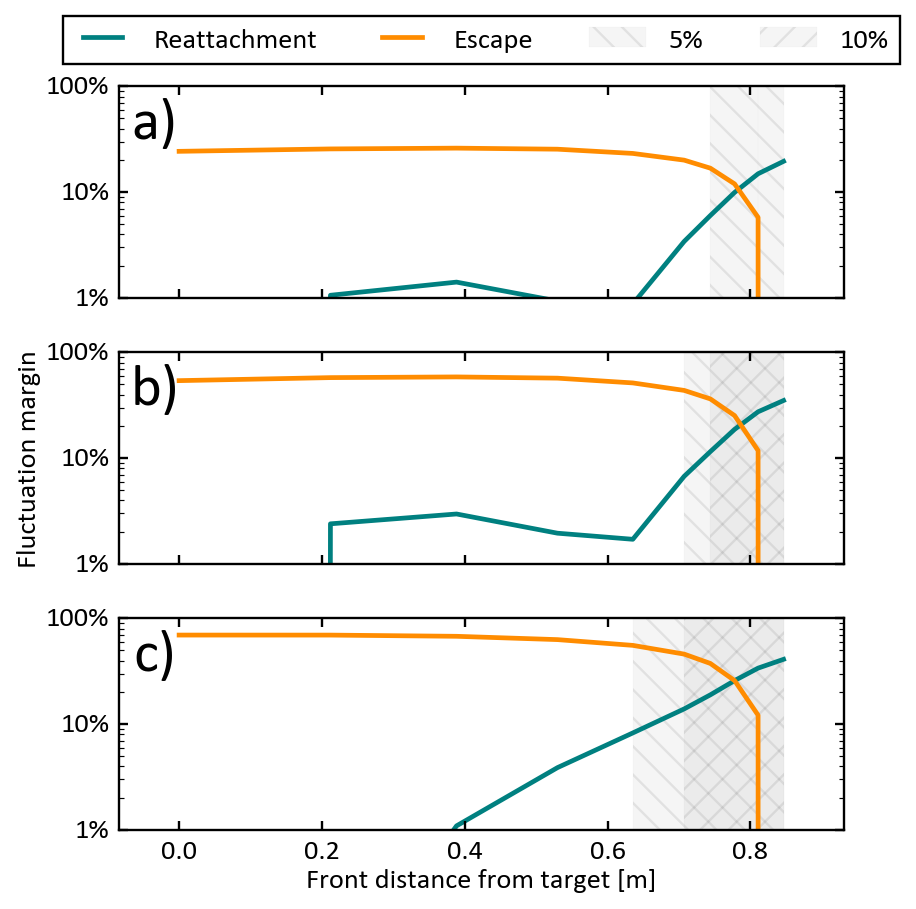

In [17]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\python-packages\matplotlib_styles\mike.mplstyle")
side = "il"
cvar = "density"
sepadd = 0

o = store[sepadd][cvar][side].copy()
d = eqb[sepadd][side].copy()

edges = {}

fig, axes = plt.subplots(3,1, figsize = (5,5), dpi = 170, sharex = True)

fig.subplots_adjust(hspace=0)
fig.tight_layout()

# dashes = ["solid", "dashed", "dashdot"]
titles = ["a)", "b)", "c)"]
for i, cvar in enumerate(["density", "impurity_frac", "power"]):
    o = store[sepadd][cvar][side]
    crel = 1/o["crel"] if cvar == "power" else o["crel"]
    ax = axes[i]
    margin1 = abs((crel[0] - crel)/crel)
    margin2 = abs((crel[-1] - crel)/crel)

    x = o["SpolPlot"]; ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    # x = o["Splot"]; ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.plot(x, margin1, label = "Reattachment")
    ax.plot(x, margin2, label = "Escape")
    # ax.plot((crel[-1] - crel)/crel, o["SpolPlot"], color = "black", label = "Allowable cvar increase before escape")

    # ax.hlines(0.05, x[0], x[-1]*1.05, colors = "r", lw = 2, ls = "-", label = "5% fluctuation")
    start1 = np.where(margin1 > 0.05)[0][0]
    end1  = np.where(margin2 < 0.05)[0][0]
    start2 = np.where(margin1 > 0.10)[0][0]
    end2 = np.where(margin2 < 0.10)[0][0]
    
    ax.fill_between(
        [x[start1],
         x[end1]], 
                    y1 = 1e-3, y2 = 2, color = "grey", alpha = 0.08, label = "5%", hatch = "\\\\", edgecolor = "k", linewidth = 0.1)
    
    ax.fill_between(
        [x[start2],
         x[end2]], 
                    y1 = 1e-3, y2 = 2, color = "grey", alpha = 0.08, label = "10%", hatch = "//", edgecolor = "k", linewidth = 0.1)


    if i == 0: ax.legend(loc="upper center", ncols=4, framealpha = 1, bbox_to_anchor=(0.5, 1.4))
    ax.set_title(titles[i], y=0.70, x = 0.05, fontsize = 25)
    if i == 2: ax.set_xlabel("Front distance from target [m]")
    if i == 1: ax.set_ylabel("Fluctuation margin")
    
    
    ax.grid(which="minor", c = "k", alpha = 0.1, lw = 0.5)
    ax.grid(which="major", c = "k", alpha = 0.4, lw = 0.5)
    ax.grid(which="both", alpha = 0)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))

    ax.set_ylim(0.01,1)
    # ax.set_ylim(-0.1,1.1)
    

# Compare SOL ring flux expansion

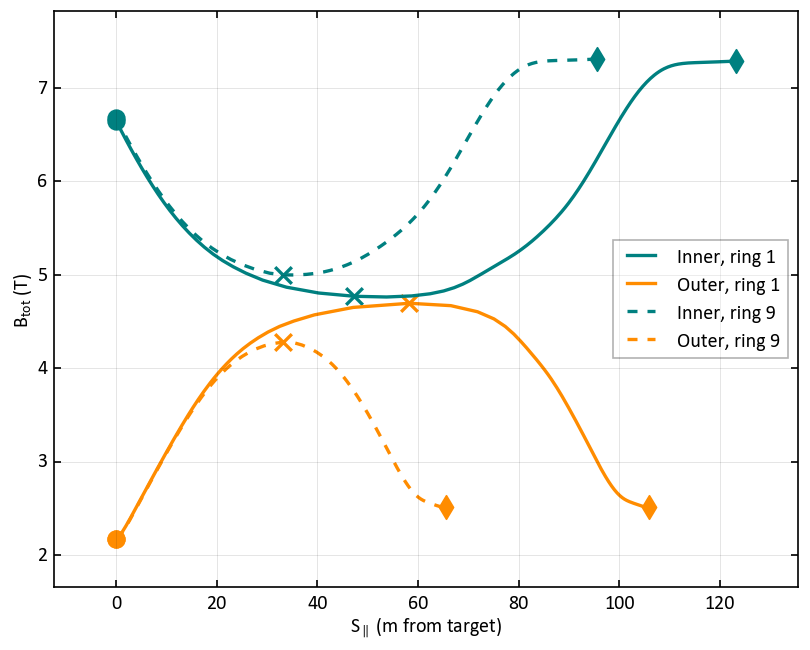

In [106]:
fig, ax = plt.subplots(dpi = 120, figsize = (8,6))
colors = mike_cmap(2)
labels = {"ol":"Outer", "il":"Inner"}
lstyles = ["-", "--"]
size = 100

for sepid, sepadd in enumerate([1,9]):
    for i, side in enumerate(["il", "ol"]):
        d = eqb[sepadd][side]
        Xpoint = d["Xpoint"]
        ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side] + f", ring {sepadd}", ls = lstyles[sepid])
        ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
        ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
        ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

# h,l = ax.get_legend_handles_labels()
# extra_handles = [
#     mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
#     mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
#     mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, 
        #   handles = h+extra_handles
          )

# Plot basic results

Text(0.5, 1.0, 'Inner divertor')

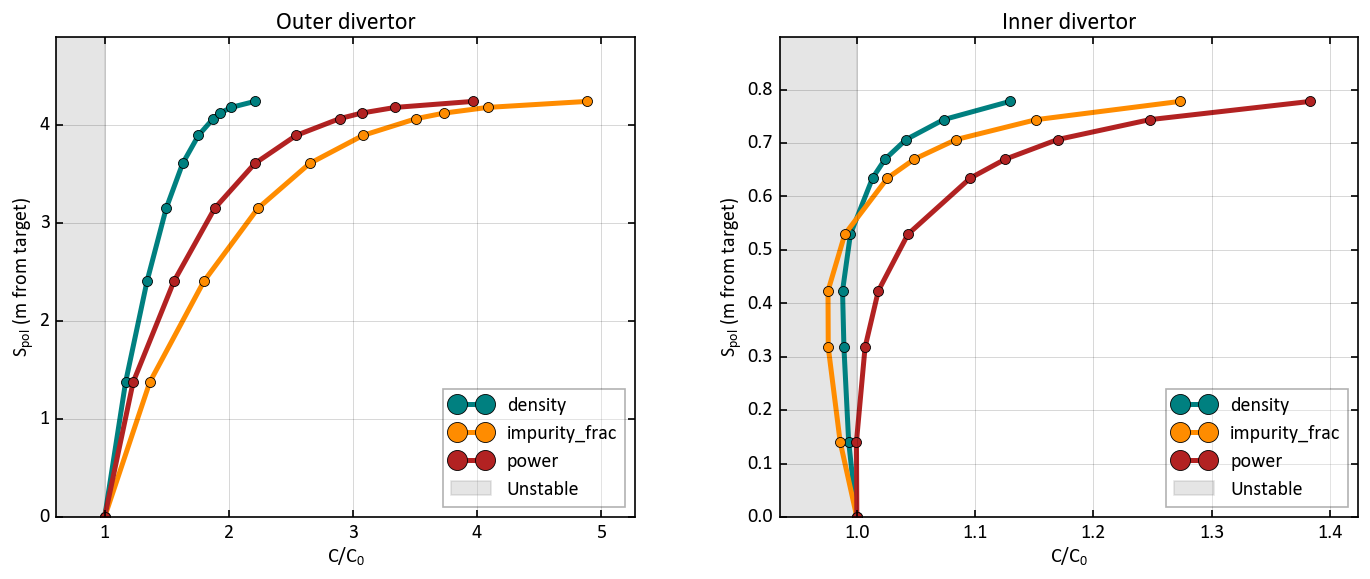

In [90]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)
cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (14,5))
# fig.suptitle("Density scan of front profiles")
ax = axes[0]

basis = "crel"
sepadd = 1

for k, side in enumerate(["ol", "il"]):


    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        
        o = store[sepadd][cvar][side].copy()
        x = o[basis]        
        if cvar == "power":
            x = 1/x
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3,  color = colors[i], label = cvar)


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C/C_{0}$")
    # ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

# Safety margin

(-0.1, 0.5)

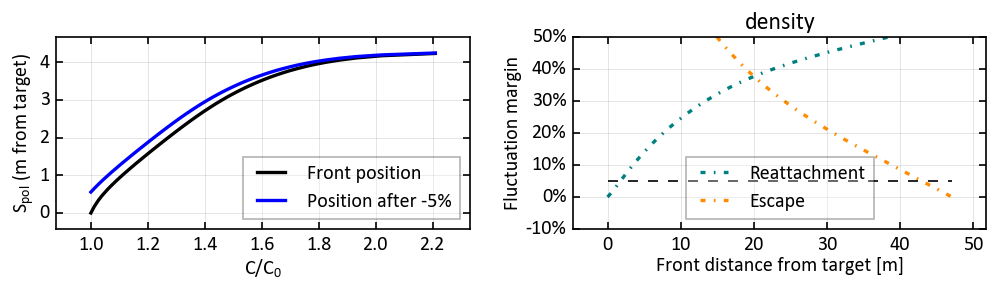

In [72]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\python-packages\matplotlib_styles\mike.mplstyle")
side = "ol"
cvar = "density"

o = store[cvar][side].copy()
d = eqb["SPR45_new"][side].copy()
# crel = o["cvar"]
crel = 1/o["crel"] if cvar == "power" else o["crel"]
# crel -= 1

base_spol = interpolate.interp1d(crel, o["SpolPlot"], kind = "cubic")
negative_spol = interpolate.interp1d(crel-0.05, o["SpolPlot"], fill_value="extrapolate", kind = "cubic")

negative = [negative_spol(x) for x in crel]

fig, axes = plt.subplots(1,2, figsize = (10,2), dpi = 120)
ax = axes[0]
ax.plot(crel, o["SpolPlot"], color = "black", label = "Front position")
# ax.plot(o["crel"], [base_spol(x) for x in o["crel"]], color = "black", label = "Front position")
ax.plot(crel, negative, label = "Position after -5%", color = "blue")
# ax.plot(o["crel"]+0.05, o["SpolPlot"], label = "Position after +5%", color = "red")
ax.set_xlabel("$C / C_{0}$")
ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
ax.legend()


ax = axes[1]

dashes = ["solid", "dashed", "dashdot"]
# for i, cvar in enumerate(["density", "impurity_frac", "power"]):
# o = store[cvar]["ou"]

margin1 = abs((crel[0] - crel)/crel)
margin2 = abs((crel[-1] - crel)/crel)

x = o["Splot"]
ax.plot(x, margin1, label = "Reattachment", ls = dashes[i])
ax.plot(x, margin2, label = "Escape", ls = dashes[i])
# ax.plot((crel[-1] - crel)/crel, o["SpolPlot"], color = "black", label = "Allowable cvar increase before escape")

ax.hlines(0.05, x[0], x[-1], colors = "k", lw = 1, ls = "--")

ax.legend()
ax.set_title(f"{cvar}")
ax.set_xlabel("Front distance from target [m]")
ax.set_ylabel("Fluctuation margin")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_ylim(-0.1,0.5)

density, 0.70
power, 0.63
impurity_frac, 0.38


Text(0, 0.5, 'Band width (m poloidal)')

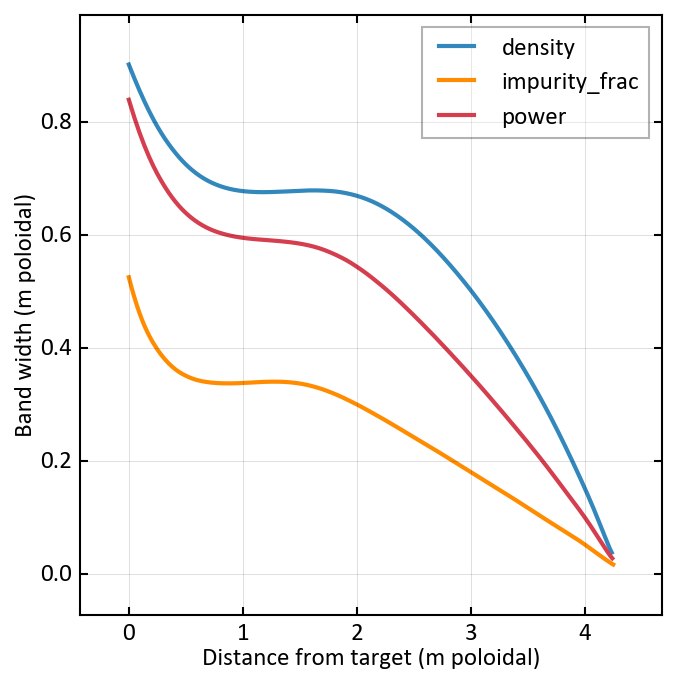

In [71]:
band_widths = {}
size = 0.05
side = "ou"
for cvar in ["power", "impurity_frac", "density"]:
    d = eqb["SPR45"][side]
    o = store[cvar][side]
    
    # Find first valid index
    # This trims the unstable region on the inner
    # trim_idx = 0
    # for i,_ in enumerate(o["cvar_trim"]):
    #     if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
    #         trim_idx = i+1
        
    # Make band based on topology dictionary (d) and results dictionary (o)
    # and a desired S poloidal location of the band centre (spol_middle)
    # as well as band size as a fraction (default +/-5%)
    trim_idx = 0
    crel = np.array(o["crel"])[trim_idx:]
    splot = np.array(o["Splot"])[trim_idx:]
    spolplot = np.array(o["SpolPlot"])[trim_idx:]

    if cvar == "power":
        crel = 1/crel

    c_grid = np.linspace(crel[0], crel[-1], 1000)
    k = 5
    spar_interp = interpolate.interp1d(crel, splot, kind="cubic", fill_value = "extrapolate")
    spol_interp = interpolate.interp1d(crel, spolplot, kind="cubic", fill_value = "extrapolate")

    band_widths[cvar] = []
    for i, c_start in enumerate(c_grid):
        c_middle = c_start/(1-size)
        c_end = c_middle*(1+size)

        spar_start = spar_interp(c_start)
        spar_middle = spar_interp(c_middle)
        spar_end = spar_interp(c_end)

        spol_start = spol_interp(c_start)
        spol_middle = spol_interp(c_middle)
        spol_end = spol_interp(c_end)

        # band_widths.append(s_end - s_start)
        # band_widths.append(interp(c_start/(1-size)*(1+size)) - interp(c_start))
        band_width = spol_end - spol_start
        # band_width = spar_end - spar_start

        if band_width <= 0:
            band_widths[cvar].append(np.nan)
        elif spol_end > spolplot[-1]:
            band_widths[cvar].append(np.nan)
        else:
            band_widths[cvar].append(band_width)



fig, ax = plt.subplots(figsize=(5,5), dpi = 150)
x = spol_interp(c_grid)
ax.plot(x, band_widths["density"], label = "density", color = "#3288bd")
ax.plot(x, band_widths["impurity_frac"], label = "impurity_frac", color = "darkorange")
ax.plot(x, band_widths["power"], label = "power", color = "#d53e4f")

for cvar in ["density", "power", "impurity_frac"]:
    for i, _ in enumerate(x):
        if x[i] > band_widths[cvar][i]:
            idx = i
            print(f"{cvar}, {x[i]:.2f}")
            break
    # ax.scatter(x[i], band_widths[cvar][i], marker = "x", c = "k", s = 100, zorder = 100)


ax.legend(fontsize = 12)
ax.set_xlabel("Distance from target (m poloidal)")
ax.set_ylabel("Band width (m poloidal)")
    # band_width(2, interp)

density, 0.70
power, 0.63
impurity_frac, 0.38


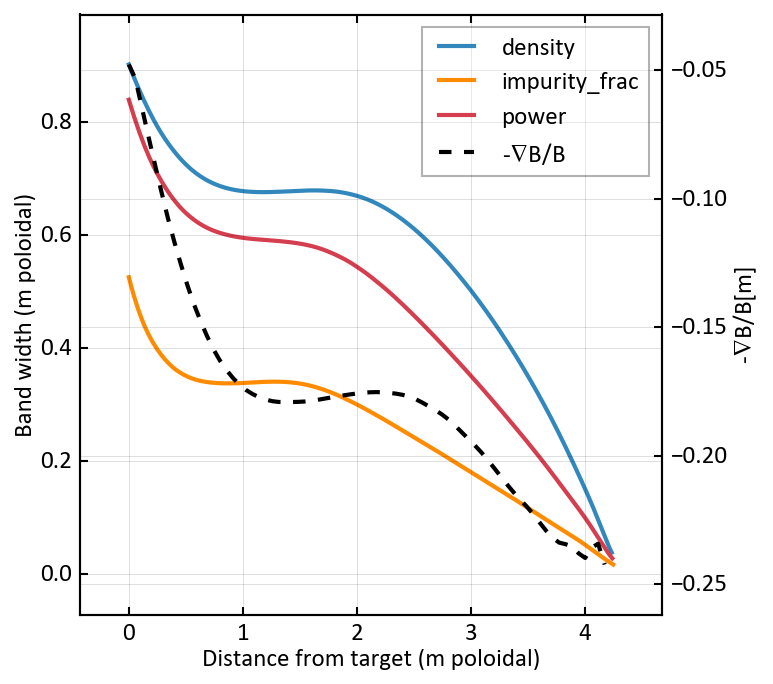

In [72]:

# d = eqb["SPR45"]["ou"]
Xpoint = d["Xpoint"]
B = d["Btot"]
S = d["Spol"]
gradB = -np.gradient(B, S)
frac_gradB = gradB/B



fig, ax = plt.subplots(figsize=(5,5), dpi = 150)
x = spol_interp(c_grid)
ax.plot(x, band_widths["density"], label = "density", color = "#3288bd")
ax.plot(x, band_widths["impurity_frac"], label = "impurity_frac", color = "darkorange")
ax.plot(x, band_widths["power"], label = "power", color = "#d53e4f")

for cvar in ["density", "power", "impurity_frac"]:
    for i, _ in enumerate(x):
        if x[i] > band_widths[cvar][i]:
            idx = i
            print(f"{cvar}, {x[i]:.2f}")
            break
    # ax.scatter(x[i], band_widths[cvar][i], marker = "x", c = "k", s = 100, zorder = 100)



ax.set_xlabel("Distance from target (m poloidal)")
ax.set_ylabel("Band width (m poloidal)")

ax2 = ax.twinx()
ax2.plot(d["Spol"][:Xpoint],frac_gradB[:Xpoint], label = "-$\\nabla B / B$", color = "k", ls = "--")
ax2.set_ylabel("-$\\nabla B / B [m]$")

fig.legend(fontsize = 12, loc = "upper right", bbox_to_anchor=(0.9,0.9))

In [214]:
i = 0
crel = store["density"]["ou"]["cvar"]
# escape = ((crel[-1] - crel[i])/crel[i])
escape = (crel[-1] - crel[i])/crel[i]

print(f"Pos: {o['SpolPlot'][i]:.1f}, Crel: {crel[i]:.1f}")
print(f"Crel distance to escape: {crel[-1]-crel[i]:.1f}")
print(f"Crel ratio to escape: {crel[-1]/crel[i]:.1f}")
print(f"Fluctuation to escape: +{escape:.0%}")

Pos: 0.0, Crel: 51660156249999998976.0
Crel distance to escape: 87402343750000001024.0
Crel ratio to escape: 2.7
Fluctuation to escape: +169%


# Read detachment bands

## Band function

In [36]:
# def make_window_band(d, o, spol_middle, size = 0.05):
    
side = "iu"
cvar = "density"
d = eqb["SPR45"][side]
o = store[cvar][side]
spol_middle = 3

# Find first valid index
for i,_ in enumerate(o["cvar_trim"]):
    if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
        trim_idx = i
    
# Make band based on topology dictionary (d) and results dictionary (o)
# and a desired S poloidal location of the band centre (spol_middle)
# as well as band size as a fraction (default +/-5%)

crel = np.array(o["crel"])[trim_idx:]
splot = np.array(o["Splot"])[trim_idx:]
spolplot = np.array(o["SpolPlot"])[trim_idx:]
Btot = d["Btot"]
Btot_grad = np.gradient(Btot)

c_grid = np.linspace(crel[0], crel[-1], 1000)

In [38]:

# Need continuous functions for the front locations and corresponding control variables.
spar_from_crel = interpolate.UnivariateSpline(crel, splot, k= 5)
spol_from_crel = interpolate.UnivariateSpline(crel, spolplot, k= 5)
crel_from_spol = interpolate.UnivariateSpline(spolplot, crel, k= 5)

In [40]:



c_middle = crel_from_spol(spol_middle)

# Band control variable for middle and both ends.
band = dict()
band["C"] = [None] * 3
band["C"][0] = c_middle * (1-size)
band["C"][1] = c_middle
band["C"][2] = c_middle * (1+size)

# The dictionary "band" contains several parameters. Each parameter contains a list of three 
# values corresponding to the three points of the band. In this way band["Btot"] has a list of the
# total B values across the band.
for param in ["Spar", "Spol", "index", "R", "Z", "Btot"]:
    band[param] = np.array([float]*3)

for i in range(3):
    band["Spar"][i] = spar_from_crel(band["C"][i])    
    band["Spol"][i] = spol_from_crel(band["C"][i])
    band["index"][i] = np.argmin(np.abs(d["S"] - band["Spar"][i]))
    band["R"][i] = d["R"][band["index"][i]]
    band["Z"][i] = d["Z"][band["index"][i]]
    band["Btot"][i] = d["Btot"][band["index"][i]]
    
band["width_pol"] = band["Spol"][2] - band["Spol"][0] # Band width in poloidal
band["width_par"] = band["Spar"][2] - band["Spar"][0] # Band width in parallel
band["Btot_avg"] = np.mean(Btot[band["index"][0]:band["index"][2]])
band["Btot_grad_avg"] = np.mean(Btot_grad[band["index"][0]:band["index"][2]])

# return band

In [57]:
def make_window_band(d, o, spol_middle, size = 0.05):
    # Find first valid index
    # This trims the unstable region on the inner
    trim_idx = 0
    for i,_ in enumerate(o["cvar_trim"]):
        if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
            trim_idx = i
        
    # Make band based on topology dictionary (d) and results dictionary (o)
    # and a desired S poloidal location of the band centre (spol_middle)
    # as well as band size as a fraction (default +/-5%)

    crel = np.array(o["crel"])[trim_idx:]
    splot = np.array(o["Splot"])[trim_idx:]
    spolplot = np.array(o["SpolPlot"])[trim_idx:]

    
    if spol_middle < spolplot[0] or spol_middle > spolplot[-1]:
        raise ValueError(f"spol_middle is {spol_middle:.2f} outside of valid range. Must be within {spolplot[0]:.2f} - {spolplot[-1]:.2f}")
    
    Btot = d["Btot"]
    Btot_grad = np.gradient(Btot)

    c_grid = np.linspace(crel[0], crel[-1], 1000)

    # Need continuous functions for the front locations and corresponding control variables.
    spar_from_crel = interpolate.UnivariateSpline(crel, splot, k= 5)
    spol_from_crel = interpolate.UnivariateSpline(crel, spolplot, k= 5)
    crel_from_spol = interpolate.UnivariateSpline(spolplot, crel, k= 5)

    c_middle = crel_from_spol(spol_middle)
    
    # Band control variable for middle and both ends.
    band = dict()
    band["C"] = [None] * 3
    band["C"][0] = c_middle * (1-size)
    band["C"][1] = c_middle
    band["C"][2] = c_middle * (1+size)

    # The dictionary "band" contains several parameters. Each parameter contains a list of three 
    # values corresponding to the three points of the band. In this way band["Btot"] has a list of the
    # total B values across the band.
    for param in ["Spar", "Spol", "index", "R", "Z", "Btot"]:
        band[param] = np.array([float]*3)

    for i in range(3):
        band["Spar"][i] = spar_from_crel(band["C"][i])    
        band["Spol"][i] = spol_from_crel(band["C"][i])
        band["index"][i] = np.argmin(np.abs(d["S"] - band["Spar"][i]))
        band["R"][i] = d["R"][band["index"][i]]
        band["Z"][i] = d["Z"][band["index"][i]]
        band["Btot"][i] = d["Btot"][band["index"][i]]
        
    band["width_pol"] = band["Spol"][2] - band["Spol"][0] # Band width in poloidal
    band["width_par"] = band["Spar"][2] - band["Spar"][0] # Band width in parallel
    band["Btot_avg"] = np.mean(Btot[band["index"][0]:band["index"][2]])
    band["Btot_grad_avg"] = np.mean(Btot_grad[band["index"][0]:band["index"][2]])

    return band

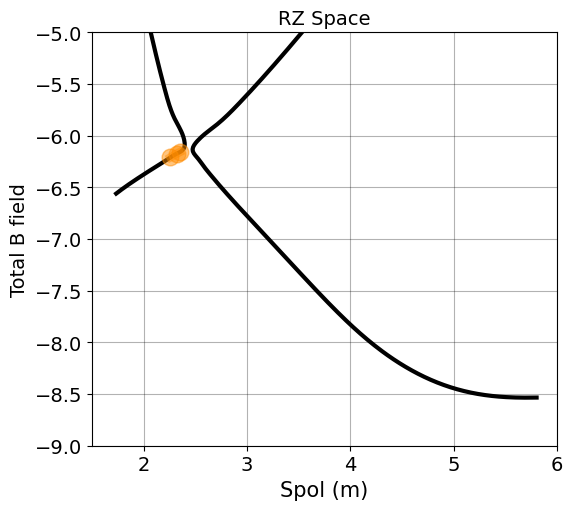

In [25]:
fig, ax = plt.subplots(1, figsize = (6,12))
k = 6
side = "iu"
cvar = "power"
d = eqb["SPR45"][side]
d_inner = eqb["SPR45"]["iu"]
d_outer = eqb["SPR45"]["ou"]
o = store[cvar][side]
spol1 = 0.7
if cvar == "power":
    o["crel"] = 1/o["crel"]

band = make_window_band(d, o, 0.5) # Make band at 3m

ax.plot(d_inner["R"], d_inner["Z"]*-1, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_outer["R"], d_outer["Z"]*-1, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-9, -5)
ax.set_xlim(1.5,6)

alpha = 0.5
ax.set_title("RZ Space")
ax.plot(make_window_band(d, o, spol1)["R"], make_window_band(d, o, spol1)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "darkorange", alpha = alpha)
ax.plot(d["Spol"], d["Btot"]); 
ax.set_xlabel("Spol (m)"); ax.set_ylabel("Total B field")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

## Compute bands

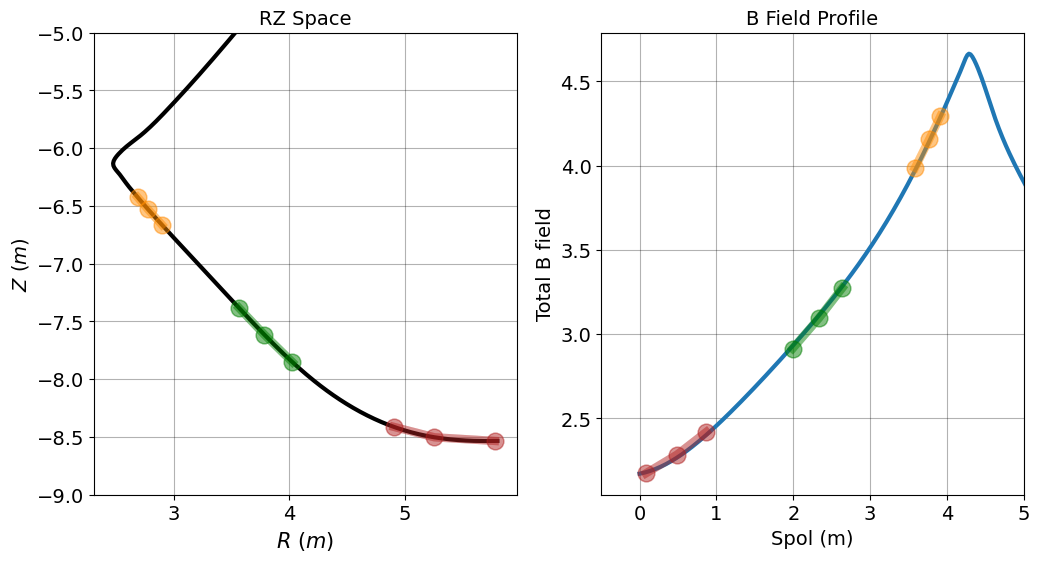

In [10]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
k = 6
side = "ou"
cvar = "density"
d = eqb["SPR45"][side]
o = store[cvar][side]

band = make_window_band(d, o, 1) # Make band at 3m

ax = axes[0]
ax.plot(d["R"], d["Z"]*-1, label = "Morph factor 1".format(side), linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-9, -5)

ax.set_title("RZ Space")
color = "red"

spol1 = 3.8
spol2 = 2.2
spol3 = 0.2
alpha = 0.2

for point in range(3):
    ax.plot(make_window_band(d, o, spol1)["R"], make_window_band(d, o, spol1)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "darkorange", alpha = alpha)
    ax.plot(make_window_band(d, o, spol2)["R"], make_window_band(d, o, spol2)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "green", alpha = alpha)
    ax.plot(make_window_band(d, o, spol3)["R"], make_window_band(d, o, spol3)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "firebrick", alpha = alpha)

ax = axes[1]
ax.plot(d["Spol"], d["Btot"]); 
ax.set_xlabel("Spol (m)"); ax.set_ylabel("Total B field")

for point in range(3):
    ax.plot(make_window_band(d, o, spol1)["Spol"], make_window_band(d, o, spol1)["Btot"], markersize = 12, marker = "o", linewidth = 6, color = "darkorange", alpha = alpha)
    ax.plot(make_window_band(d, o, spol2)["Spol"], make_window_band(d, o, spol2)["Btot"], markersize = 12, marker = "o", linewidth = 6, color = "green", alpha = alpha)
    ax.plot(make_window_band(d, o, spol3)["Spol"], make_window_band(d, o, spol3)["Btot"], markersize = 12, marker = "o", linewidth = 6, color = "firebrick", alpha = alpha)

ax.set_title("B Field Profile")
ax.set_xlim(-0.5,5)
for ax in axes:
    ax.grid(alpha = 0.3, color = "k")

In [84]:
# i = 0
side = "iu"
cvar = "power"
d = eqb["SPR45"][side]
o = store[cvar][side]

crel = np.array(o["crel"])

if cvar == "power":
    crel = 1/crel

if side == "iu":
    flipper = -1
else:
    flipper = 1    

crel = o["crel"]
splot = np.array(o["Splot"])
spolplot = np.array(o["SpolPlot"])

c_grid = np.linspace(crel[0], crel[-1], 1000)

crel = crel[::flipper]
k = 5
spar_interp = interpolate.UnivariateSpline(crel, splot, k = k)
spol_interp = interpolate.UnivariateSpline(crel, spolplot, k = k)

# Check interpolation
fig, ax = plt.subplots()
ax.plot(crel, spolplot)
ax.plot(crel, spol_interp(crel)[::flipper])
ax.set_xlabel("Crel")
ax.set_ylabel("Spar")


ValueError: x must be increasing if s > 0

## Continuous bands for the three control variables

In [11]:
cvar = "density"
side = "iu"
d = eqb["SPR45"][side]
o = store[cvar][side]

# Find first valid index
# This trims the unstable region on the inner
trim_idx = 0
for i,_ in enumerate(o["cvar_trim"]):
    if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
        trim_idx = i+1
        
crel = np.array(o["crel"])[trim_idx:]
splot = np.array(o["Splot"])[trim_idx:]
spolplot = np.array(o["SpolPlot"])[trim_idx:]

spol_from_crel = interpolate.InterpolatedUnivariateSpline(crel, spolplot)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(crel, spolplot, label = "original")
ax.plot(crel, [spol_from_crel(x) for x in crel], label = "fit")
ax.set_xlabel("crel")
ax.set_ylabel("SpolPlot")
ax.legend()

ValueError: x must be strictly increasing

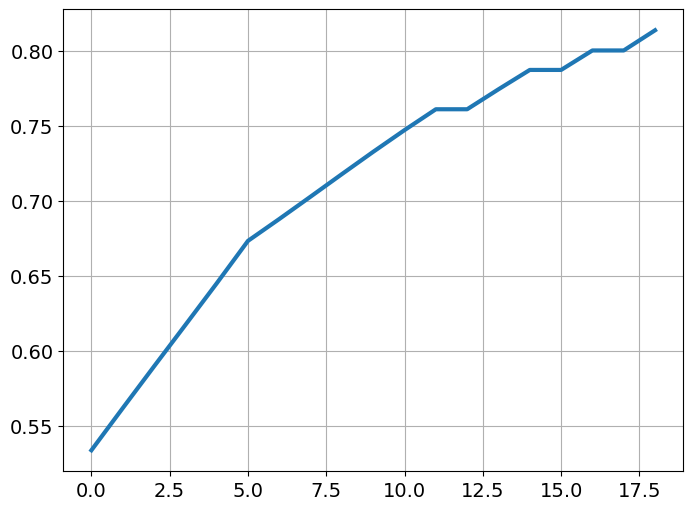

In [40]:
plt.plot(spolplot)

In [16]:
len(store[cvar][side]["crel"])

100

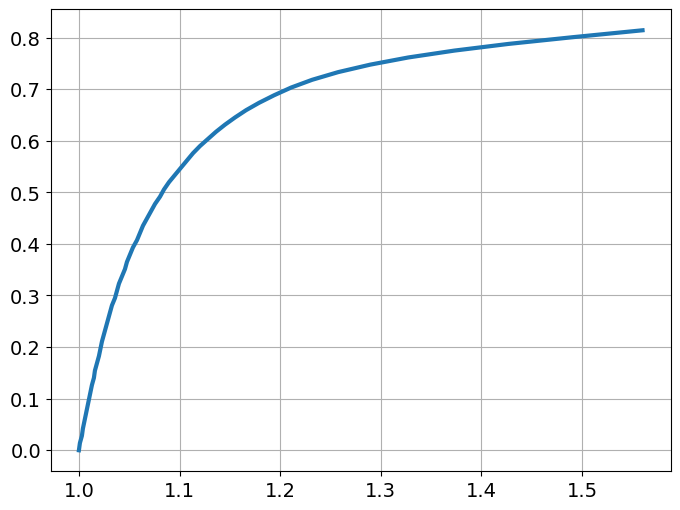

In [20]:
plt.plot(1/o["crel"], o["SpolPlot"])

In [13]:
len(crel)

2